In [2]:
!pip install sickle pandas

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 30.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [1]:
# Step 1: Import necessary libraries
from sickle import Sickle  # For OAI-PMH harvesting
import pandas as pd  # For data manipulation and analysis
import time  # For implementing delays
from requests.exceptions import RequestException  # For error handling
from lxml import etree  # For XML parsing

# Step 2: Define a function to parse each record
def parse_record(record):
    """
    Parse an OAI-PMH record and extract relevant metadata fields.
    
    :param record: An OAI-PMH record object
    :return: A dictionary containing parsed metadata
    """
    # Parse the XML content of the record
    root = etree.fromstring(record.raw)
    
    # Define namespace
    ns = {'oai_dc': 'http://www.openarchives.org/OAI/2.0/oai_dc/',
          'dc': 'http://purl.org/dc/elements/1.1/'}
    
    # Extract metadata
    get_text = lambda tag: '; '.join(e.text for e in root.findall(f'.//dc:{tag}', ns) if e.text)
    
    return {
        'identifier': record.header.identifier,  # Unique identifier for the record
        'datestamp': record.header.datestamp,  # Last modification date of the record
        'title': metadata.get('title', [None])[0],  # Title of the work
        'creator': '; '.join(metadata.get('creator', [])),  # Author(s) of the work
        'date': '; '.join(metadata.get('date', [])),  # Relevant dates (e.g., publication, submission)
        'description': '; '.join(metadata.get('description', [])),  # Abstract or other descriptions
        'subject': '; '.join(metadata.get('subject', [])),  # Subject terms or keywords
        'publisher': metadata.get('publisher', [None])[0],  # Publisher information
        'type': '; '.join(metadata.get('type', [])),  # Type of the work (e.g., thesis, dissertation)
        'language': metadata.get('language', [None])[0],  # Language of the work
        'relation': '; '.join(metadata.get('relation', [])),  # Related information (e.g., report numbers)
        'identifier_url': metadata.get('identifier', [None])[0],  # URL or DOI of the work
    }

# Step 3: Set up the OAI-PMH client
base_url = "https://www.ideals.illinois.edu/oai-pmh"
sickle = Sickle(base_url)

# Step 4: Define harvesting parameters
metadata_prefix = "oai_dc"  # We're using the Dublin Core metadata format
set_spec = "com_2142_5130"  # Graduate Dissertations and Theses at Illinois

/Users/amirawu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Step 5: Harvest the records
print("Starting the harvesting process...")
records = []
retries = 3 # Number of retry attempts for each record
for record in sickle.ListRecords(metadataPrefix=metadata_prefix, set=set_spec):
    for attempt in range(retries):
        try:
            parsed_record = parse_record(record)
            records.append(parsed_record)
            if len(records) % 1000 == 0:
                print(f"Harvested {len(records)} records...")
                time.sleep(1) # Sleep for 1 second every 1000 records to avoid overwhelming the server
            break # Exit the retry loop if successful
        except RequestException as e:
            if attempt < retries - 1:
                print(f"Error occurred: {e}. Retrying in 5 seconds...")
                time.sleep(5)
            else:
                print(f"Failed to harvest record after {retries} attempts.")

print(f"Total records harvested: {len(records)}")

Starting the harvesting process...
Harvested 1000 records...
Harvested 2000 records...
Harvested 3000 records...
Harvested 4000 records...
Harvested 5000 records...
Harvested 6000 records...
Harvested 7000 records...
Harvested 8000 records...
Harvested 9000 records...
Harvested 10000 records...
Harvested 11000 records...
Harvested 12000 records...
Harvested 13000 records...
Harvested 14000 records...
Harvested 15000 records...
Harvested 16000 records...
Harvested 17000 records...
Harvested 18000 records...
Harvested 19000 records...
Harvested 20000 records...
Harvested 21000 records...
Harvested 22000 records...
Harvested 23000 records...
Harvested 24000 records...
Harvested 25000 records...
Harvested 26000 records...
Harvested 27000 records...
Harvested 28000 records...
Harvested 29000 records...
Harvested 30000 records...
Harvested 31000 records...
Harvested 32000 records...
Harvested 33000 records...
Harvested 34000 records...
Harvested 35000 records...
Harvested 36000 records...
Ha

In [3]:
# Step 6: Convert the harvested records to a pandas DataFrame
df = pd.DataFrame(records)

# Step 7: Save the data to a CSV file
df.to_csv('uiuc_etd_metadata.csv', index=False)
print("Data saved to uiuc_etd_metadata.csv") # Save locally 


Data saved to uiuc_etd_metadata.csv


In [4]:
# Step 8: Perform basic analysis on the harvested data
print("\nBasic analysis of the harvested data:")
print(f"Total number of records: {len(df)}")

# Calculate the date range, assuming the first date in the list is the most relevant
print(f"Date range: from {df['date'].str.split(';').str[0].min()} to {df['date'].str.split(';').str[0].max()}")



Basic analysis of the harvested data:
Total number of records: 53471
Date range: from  to 2024-09-16T10:20:27-05:00


In [12]:
import pandas as pd
from datetime import datetime

# Load the CSV file
df = pd.read_csv('uiuc_etd_metadata.csv')

# Function to extract the earliest and latest dates
def extract_dates(date_string):
    if pd.isna(date_string):
        return pd.NaT, pd.NaT
    dates = date_string.split(';')
    valid_dates = []
    for date in dates:
        try:
            parsed_date = pd.to_datetime(date.strip(), errors='coerce')
            if not pd.isna(parsed_date):
                # Convert to UTC and then remove timezone info
                if parsed_date.tzinfo is not None:
                    parsed_date = parsed_date.tz_convert('UTC').tz_localize(None)
                valid_dates.append(parsed_date)
        except:
            continue
    if valid_dates:
        return min(valid_dates), max(valid_dates)
    else:
        return pd.NaT, pd.NaT

# Apply the function to create new 'earliest_date' and 'update_date' columns
df['earliest_date'], df['update_date'] = zip(*df['date'].apply(extract_dates))

# Set the last_modified_date
last_modified_date = pd.to_datetime("2023-07-10")
print(f"Last modified date: {last_modified_date}")

# Identify records where 'update_date' is after last_modified_date
future_records = df[df['update_date'] > last_modified_date]
print(f"Number of records with update dates after {last_modified_date}: {len(future_records)}")

if not future_records.empty:
    print("\nSample of records with future update dates:")
    print(future_records[['identifier', 'title', 'earliest_date', 'update_date']].head())
    
    # Count records by year for future update dates
    future_years = future_records['update_date'].dt.year.value_counts().sort_index()
    print("\nDistribution of records with future update dates by year:")
    print(future_years)
else:
    print("No records found with update dates after 2023-07-10.")

# Additional analysis: Check for records with update_date equal to last_modified_date
records_on_last_date = df[df['update_date'].dt.date == last_modified_date.date()]
print(f"\nNumber of records with update date equal to last modified date: {len(records_on_last_date)}")

if not records_on_last_date.empty:
    print("\nSample of records with update date equal to last modified date:")
    print(records_on_last_date[['identifier', 'title', 'earliest_date', 'update_date']].head())

# Distribution of earliest dates
print("\nDistribution of earliest dates by year:")
earliest_years = df['earliest_date'].dt.year.value_counts().sort_index()
print(earliest_years) 

Last modified date: 2023-07-10 00:00:00
Number of records with update dates after 2023-07-10 00:00:00: 3338

Sample of records with future update dates:
                                 identifier  \
317  oai:www.ideals.illinois.edu:2142/97548   
351  oai:www.ideals.illinois.edu:2142/97582   
973  oai:www.ideals.illinois.edu:2142/98611   
978  oai:www.ideals.illinois.edu:2142/98616   
983  oai:www.ideals.illinois.edu:2142/98621   

                                                 title earliest_date  \
317  Global poverty, women’s empowerment, and highe...    2017-04-14   
351  States of discretion: Black migrating bodies a...    2017-04-18   
973  A study of the effect of rest on the fatigue s...    1919-01-01   
978  Highway location in the foothills of the Rocky...    1936-01-01   
983  The viability of the nodule bacteria of legume...    1921-01-01   

            update_date  
317 2025-04-23 05:00:00  
351 2023-11-03 05:00:00  
973 2040-01-01 06:00:00  
978 2032-01-01 06:00:00  
9

In [8]:
import pandas as pd
import numpy as np
from collections import Counter

# Load the CSV file
df = pd.read_csv('uiuc_etd_metadata.csv')

# 1. Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# 2. Check for unique identifiers
if 'identifier' in df.columns:
    unique_identifiers = df['identifier'].nunique()
    print(f"Number of unique identifiers: {unique_identifiers}")
    print(f"Total rows: {len(df)}")
    print(f"Difference: {len(df) - unique_identifiers}")

# 3. Check for potential deleted records
if 'status' in df.columns:
    deleted_count = df['status'].eq('deleted').sum()
    print(f"Number of potentially deleted records: {deleted_count}")

# 4. Check set membership
if 'set' in df.columns:
    set_counts = df['set'].value_counts()
    print("\nSet distribution:")
    print(set_counts)

# 5. Investigate date distributions
date_columns = [col for col in df.columns if 'date' in col.lower()]
for col in date_columns:
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts().head())

# 6. Check for empty or null values
null_counts = df.isnull().sum()
print("\nNull value counts:")
print(null_counts[null_counts > 0])

# 7. Investigate potential partial records
column_completeness = (df.notnull().sum() / len(df) * 100).sort_values()
print("\nColumn completeness (%):")
print(column_completeness)

# 8. Check for unexpected values in key fields
key_fields = ['identifier', 'title', 'creator', 'type']
for field in key_fields:
    if field in df.columns:
        unexpected = df[df[field].astype(str).str.contains('error|unknown|invalid', case=False, na=False)]
        print(f"\nUnexpected values in {field}: {len(unexpected)}")
        if len(unexpected) > 0:
            print(unexpected[field].head())

# 9. Analyze identifier patterns
if 'identifier' in df.columns:
    identifier_patterns = df['identifier'].str.extract(r'(\D+)(\d+)')[0].value_counts()
    print("\nIdentifier patterns:")
    print(identifier_patterns)

# 10. Time range of records
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    print("\nDate range of records:")
    print(f"Earliest: {df['date'].min()}")
    print(f"Latest: {df['date'].max()}")

# 11. Check for any anomalies in record sizes
if 'abstract' in df.columns:
    df['abstract_length'] = df['abstract'].astype(str).apply(len)
    print("\nAbstract length statistics:")
    print(df['abstract_length'].describe())

# 12. Investigate potential data inconsistencies
if 'type' in df.columns and 'degree_name' in df.columns:
    inconsistencies = df[df['type'] != df['degree_name']]
    print(f"\nInconsistencies between 'type' and 'degree_name': {len(inconsistencies)}")

# 13. Check for any records with missing crucial information
crucial_fields = ['title', 'creator', 'date', 'identifier']
missing_crucial = df[df[crucial_fields].isnull().any(axis=1)]
print(f"\nRecords missing crucial information: {len(missing_crucial)}")

# 14. Analyze the distribution of records across years
if 'date' in df.columns:
    df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
    year_distribution = df['year'].value_counts().sort_index()
    print("\nDistribution of records across years:")
    print(year_distribution)

Number of duplicate rows: 0
Number of unique identifiers: 53471
Total rows: 53471
Difference: 0

Distribution of datestamp:
datestamp
2023-07-11    41027
2023-07-10     9804
2024-09-16      344
2024-07-22      340
2023-12-13      279
Name: count, dtype: int64

Distribution of date:
date
2015-09-25T22:31:09Z; 2015-09-25T22:31:09Z; 10000-01-01; 2009; 2009    7
2015-05-12T21:41:44Z; 2015-05-12T21:41:44Z; 10000-01-01; 1967; 1967    7
2015-09-25T20:39:17Z; 2015-09-25T20:39:17Z; 10000-01-01; 2007; 2007    6
2015-09-25T20:39:13Z; 2015-09-25T20:39:13Z; 10000-01-01; 2006; 2006    6
2015-09-25T22:33:25Z; 2015-09-25T22:33:25Z; 10000-01-01; 2002; 2002    6
Name: count, dtype: int64

Null value counts:
title                81
creator              83
date                 81
description        1086
subject              93
publisher         53462
type               3054
language          10395
relation          53433
identifier_url      139
dtype: int64

Column completeness (%):
publisher           0.

/var/folders/n8/pd7j7g0j3673x8rwthf6b1dh0000gn/T/ipykernel_98631/1591365594.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')



Date range of records:
Earliest: NaT
Latest: NaT

Records missing crucial information: 53471

Distribution of records across years:
Series([], Name: count, dtype: int64)


Number of records with future dates: 0

Number of records missing crucial information: 83

Sample of records missing crucial information:
                                                  title creator  \
575   The optimal starting point for antenna array d...     NaN   
585                                                 NaN     NaN   
2529                                                NaN     NaN   
2530                                                NaN     NaN   
2680                                                NaN     NaN   

                                                   date  \
575   2017-08-11T18:48:20Z; 2017-08-11T18:48:20Z; 20...   
585                                                 NaN   
2529                                                NaN   
2530                                                NaN   
2680                                                NaN   

                                   identifier  
575    oai:www.ideals.illinois.edu:2142/97809  
585    o

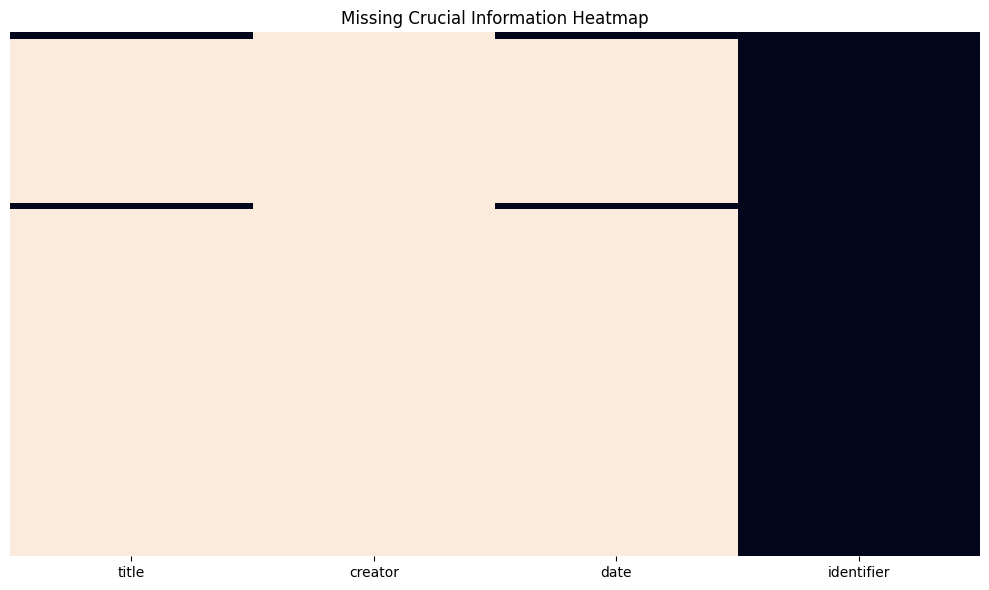


Distribution of records across years:
year
1904.0        1
1907.0        1
1949.0        1
1954.0        1
1955.0        1
1961.0        1
1964.0        7
1965.0        2
1966.0        1
1968.0        1
1969.0        2
1971.0       17
1972.0        3
1973.0        3
1974.0        2
1977.0        1
1979.0        1
1984.0        2
1985.0        3
1987.0        1
1988.0        2
1991.0        1
1993.0        7
1994.0        3
1996.0        9
1997.0        2
1998.0        5
1999.0        1
2000.0        6
2001.0        6
2002.0       10
2003.0       16
2004.0       14
2005.0       28
2006.0       20
2007.0        7
2008.0        7
2009.0      288
2010.0     1288
2011.0     6985
2012.0     1668
2013.0     1281
2014.0    17372
2015.0    11068
2016.0     1475
2017.0     1982
2018.0     1231
2019.0     1331
2020.0     1200
2021.0     1254
2022.0     1184
2023.0     1196
2024.0      343
Name: count, dtype: int64


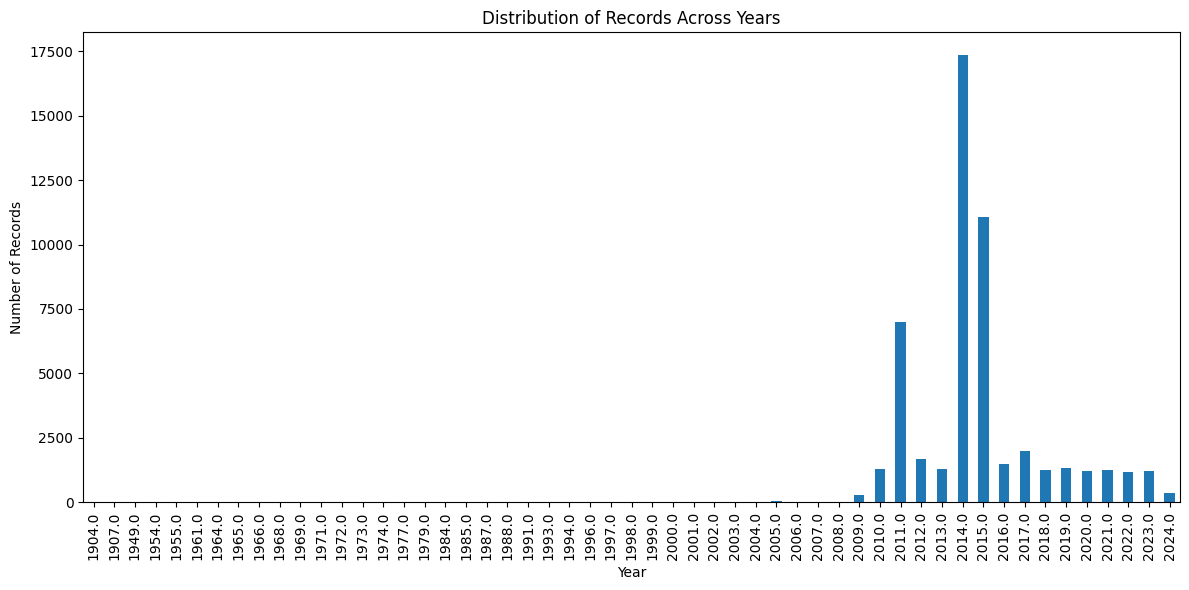


Earliest date statistics:
count                            51342
mean     2015-05-14 18:29:40.494312704
min                1904-06-01 00:00:00
25%                2014-12-01 00:00:00
50%                2014-12-15 18:51:15
75%      2015-09-28 15:15:47.750000128
max                2024-05-01 00:00:00
Name: earliest_date, dtype: object


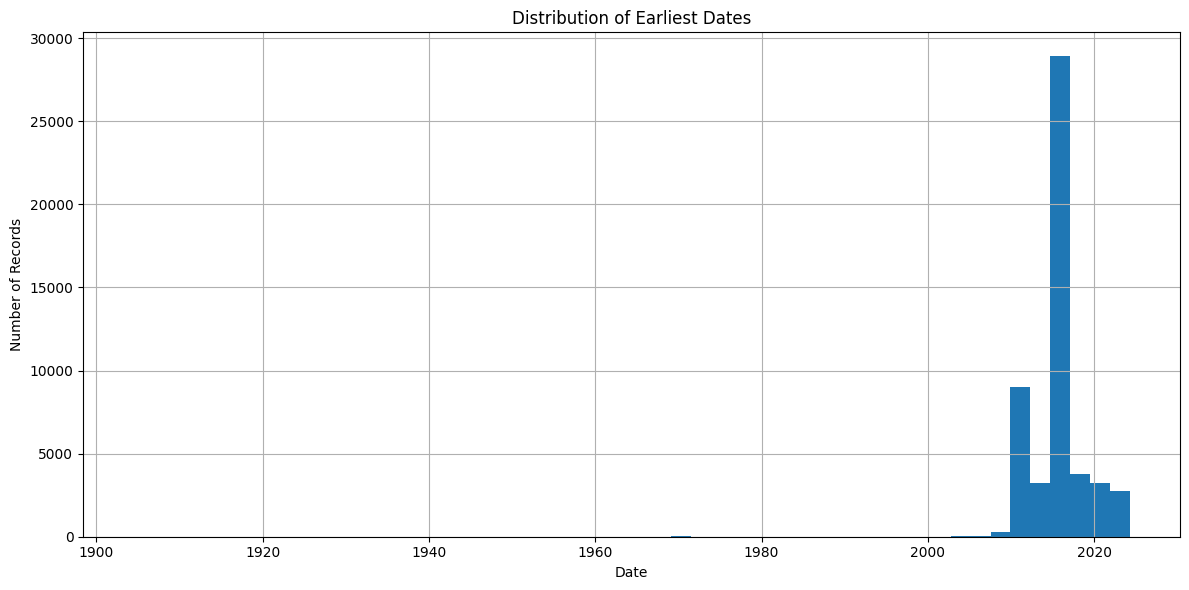

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the CSV file
df = pd.read_csv('uiuc_etd_metadata.csv')


# 3. Look into records missing crucial information
crucial_fields = ['title', 'creator', 'date', 'identifier']
missing_crucial = df[df[crucial_fields].isnull().any(axis=1)]
print(f"\nNumber of records missing crucial information: {len(missing_crucial)}")

if not missing_crucial.empty:
    print("\nSample of records missing crucial information:")
    print(missing_crucial[crucial_fields].head())

    # Count of missing values for each crucial field
    missing_counts = missing_crucial[crucial_fields].isnull().sum()
    print("\nCount of missing values for crucial fields:")
    print(missing_counts)

    # Visualize missing crucial information
    plt.figure(figsize=(10, 6))
    sns.heatmap(missing_crucial[crucial_fields].isnull(), cbar=False, yticklabels=False)
    plt.title('Missing Crucial Information Heatmap')
    plt.tight_layout()
    plt.show()

# 4. Analyze the distribution of records across years
df['year'] = df['earliest_date'].dt.year
year_distribution = df['year'].value_counts().sort_index()
print("\nDistribution of records across years:")
print(year_distribution)

# Visualize year distribution
plt.figure(figsize=(12, 6))
year_distribution.plot(kind='bar')
plt.title('Distribution of Records Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

# 5. Check for any anomalies in the earliest dates
print("\nEarliest date statistics:")
print(df['earliest_date'].describe())

# Visualize earliest date distribution
plt.figure(figsize=(12, 6))
df['earliest_date'].hist(bins=50)
plt.title('Distribution of Earliest Dates')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

In [6]:
# # Handle date analysis more robustly
# df['first_date'] = df['date'].str.split(';').str[0]
# df['first_date'] = pd.to_datetime(df['first_date'], errors='coerce')

# # Count records with valid dates
# valid_dates = df['first_date'].notna()
# print(f"Records with valid dates: {valid_dates.sum()} ({valid_dates.mean():.2%})")

# if valid_dates.any():
#     print(f"Date range: from {df['first_date'].min()} to {df['first_date'].max()}")
# else:
#     print("No valid dates found in the dataset.")

# # Show records without dates
# if not valid_dates.all():
#     print("\nSample of records without valid dates:")
#     print(df[~valid_dates][['identifier', 'title', 'date']].head())

# Handle date analysis more robustly
df['first_date'] = df['date'].str.split(';').str[0]
df['first_date'] = pd.to_datetime(df['first_date'], errors='coerce') 

# Count records with valid dates
valid_dates = df['first_date'].notna()
print(f"Records with valid dates: {valid_dates.sum()} ({valid_dates.mean():.2%})")

if valid_dates.any():
    min_date = df['first_date'].dropna().min()
    max_date = df['first_date'].dropna().max()
    print(f"Date range: from {min_date} to {max_date}")
else:
    print("No valid dates found in the dataset.")

# Show records without dates
if not valid_dates.all():
    print("\nSample of records without valid dates:")
    print(df[~valid_dates][['identifier', 'title', 'date']].head()) 


Records with valid dates: 48604 (90.90%)
Date range: from 2007-12-11 01:07:40+00:00 to 2024-09-16 10:20:27-05:00

Sample of records without valid dates:
                                 identifier  \
132  oai:www.ideals.illinois.edu:2142/97363   
151  oai:www.ideals.illinois.edu:2142/97382   
322  oai:www.ideals.illinois.edu:2142/97553   
585  oai:www.ideals.illinois.edu:2142/98092   
647  oai:www.ideals.illinois.edu:2142/98214   

                                                 title  \
132  Stability thresholds for signed Laplacians on ...   
151  Unbridled: the horses of Géricault’s English S...   
322  The α-helical conformation of polypeptides: de...   
585                                                      
647           Geometry and topological phase of matter   

                                                  date  
132  2017-04-19; 2017-05; 2017-08-10T19:15:07Z; 201...  
151  2017-04-24; 2017-08-10T19:15:17Z; 2017-08-10T1...  
322  2017-04-13; 2017-05; 2017-08-10T19:51:4

/var/folders/n8/pd7j7g0j3673x8rwthf6b1dh0000gn/T/ipykernel_98631/331536485.py:21: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['first_date'] = pd.to_datetime(df['first_date'], errors='coerce')


In [7]:
# Analyze the top 10 subjects
print("\nTop 10 subjects:")
print(df['subject'].str.split(';').explode().str.strip().value_counts().head(10))

# Analyze the document types
print("\nDocument types:")
print(df['type'].str.split(';').explode().str.strip().value_counts())


Top 10 subjects:
subject
Engineering, Electronics and Electrical    1782
Computer Science                           1192
Mathematics                                 994
Engineering, Civil                          964
Chemistry, Biochemistry                     854
Physics, Condensed Matter                   726
Chemistry, Organic                          723
Engineering, Mechanical                     691
Engineering, Materials Science              661
Education, Educational Psychology           615
Name: count, dtype: int64

Document types:
type
text                        56966
Thesis                       5238
                             3054
Dissertation / Thesis        2503
dissertation/thesis            83
Text                           12
image                           8
Technical Report                8
ger                             4
Score                           4
other                           3
Other                           2
Journal (whole)                 2
Bibl